### Setup

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.3.1'

In [3]:
# To generate GIFs
!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs
!pip install -q tensorflow_probability==0.11

# import sys
# name = 'imageio'

# if name in sys.modules:
#     import imageio
# else:
#     !pip install -q imageio
#     import imageio

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [4]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import tensorflow_probability as tfp
import time

from IPython import display

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input


!nvidia-smi --query-gpu=memory.used --format=csv

memory.used [MiB]
98 MiB


### Load and prepare the dataset

In [5]:
# (train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [6]:
# Image size that we are going to use
IMG_SIZE = 512
# Our images only utilize two channels
N_CHANNELS = 1
# Beta map has 4 values + background
N_CLASSES = 5

BATCH_SIZE = 34 # MUST DIVIDE INTO DATASET EVENLY
BUFFER_SIZE = 1000

# Seed for random number gen
SEED = 123

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [8]:
current_directory = os.getcwd()
print(current_directory)
dataset_path = current_directory +'/../Data/Dataset/Original_Depth/'
training_data = 'Training/'
val_data = 'Testing/'

/iahome/b/br/broschwartz/Developer/amlproj/tcd-dcnn/Experiments/TX_Faces/2_ErrorCorrection_ClassicGAN


In [9]:
## Load training data
# train_dataset = tf.data.Dataset.list_files(dataset_path + training_data + "*.png", seed=SEED)
# train_dataset = train_dataset.map(parse_image)


training_set_path = dataset_path + training_data
# training_set_path = dataset_path
print(type(training_set_path))
!nvidia-smi --query-gpu=memory.used --format=csv
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    training_set_path,label_mode=None,
    class_names=None, color_mode='grayscale', batch_size=BATCH_SIZE, image_size=(IMG_SIZE,
    IMG_SIZE), shuffle=True, seed=SEED, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False
)
!nvidia-smi --query-gpu=memory.used --format=csv
train_dataset = train_dataset.unbatch()
train_dataset = train_dataset.shuffle(BUFFER_SIZE, seed=SEED)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
print(train_dataset)

<class 'str'>
memory.used [MiB]
98 MiB
Found 919 files belonging to 1 classes.
memory.used [MiB]
9972 MiB
<BatchDataset shapes: (34, 512, 512, 1), types: tf.float32>


In [10]:
## Load testing data
# val_dataset = tf.data.Dataset.list_files(dataset_path + val_data + "*.png", seed=SEED)
# val_dataset =val_dataset.map(parse_image)


!nvidia-smi --query-gpu=memory.used --format=csv
validation_set_path = dataset_path + val_data
print(type(training_set_path))
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    validation_set_path,label_mode=None,
    class_names=None, color_mode='grayscale', batch_size=BATCH_SIZE, image_size=(IMG_SIZE,
    IMG_SIZE), shuffle=True, seed=SEED, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False
)
validation_dataset = validation_dataset.unbatch()
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE, seed=SEED)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=True)
!nvidia-smi --query-gpu=memory.used --format=csv

memory.used [MiB]
9972 MiB
<class 'str'>
Found 230 files belonging to 1 classes.
memory.used [MiB]
9972 MiB


In [11]:
error_data_path = current_directory + "/../Data/Dataset/Predicted_Depth/Training/"
print(type(training_set_path))
!nvidia-smi --query-gpu=memory.used --format=csv
error_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    error_data_path,label_mode=None,
    class_names=None, color_mode='grayscale', batch_size=BATCH_SIZE, image_size=(IMG_SIZE, IMG_SIZE), shuffle=True, seed=SEED, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False
)
error_dataset = error_dataset.unbatch()
# noise = error_set.take(1)
error_dataset = error_dataset.shuffle(BUFFER_SIZE, seed=SEED)
error_dataset = error_dataset.batch(BATCH_SIZE, drop_remainder=True)
!nvidia-smi --query-gpu=memory.used --format=csv

<class 'str'>
memory.used [MiB]
9972 MiB
Found 919 files belonging to 1 classes.
memory.used [MiB]
9972 MiB


In [12]:
@tf.function
def normalize(input_image: tf.Tensor) -> tuple:
    """Rescale the pixel values of the images between 0.0 and 1.0
    compared to [0,255] originally.

    Parameters
    ----------
    input_image : tf.Tensor
        Tensorflow tensor containing an image of size [SIZE,SIZE,3].
    input_mask : tf.Tensor
        Tensorflow tensor containing an annotation of size [SIZE,SIZE,1].

    Returns
    -------
    tuple
        Normalized image and its annotation.
    """
    input_image = (tf.cast(input_image, tf.float32)) / 255.0
    return input_image

In [13]:
# CREATING TRAINING DATASET GENERATOR
# !nvidia-smi --query-gpu=memory.used --format=csv
# datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=normalize)
# training_path = dataset_path + training_data
# train_dataset = datagen.flow_from_directory(training_path,
#                                              batch_size = BATCH_SIZE,
#                                              class_mode=None,
#                                              color_mode='grayscale',
#                                              target_size=(512,512))
# # CREATING VALIDATION DATASET GENERATOR
# validation_path = dataset_path + val_data
# validation_dataset = datagen.flow_from_directory(validation_path,
#                                              batch_size = BATCH_SIZE,
#                                              class_mode=None,
#                                              color_mode='grayscale',
#                                              target_size=(512,512))

# # CREATING ERROR IMAGES DATASET GENERATOR
# error_path = 'Data/Dataset/Predicted_Depth/Training/'
# error_dataset = datagen.flow_from_directory(error_path,
#                                              batch_size = BATCH_SIZE,
#                                              class_mode=None,
#                                              color_mode='grayscale',
#                                              target_size=(512,512))
# !nvidia-smi --query-gpu=memory.used --format=csv

In [14]:
# dataset = {"train": train_dataset, "val": validation_dataset}

In [15]:
# -- Train Dataset --#
# dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
# dataset['train'] = dataset['train'].repeat()
# dataset['train'] = dataset['train'].batch(BATCH_SIZE)
# dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)

In [16]:
# #-- Validation Dataset --#
# dataset['val'] = dataset['val'].map(load_image_test)
# dataset['val'] = dataset['val'].repeat()
# dataset['val'] = dataset['val'].batch(BATCH_SIZE)
# dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)

In [17]:
# train_images = train_dataset.reshape(train_dataset.shape[0], IMG_SIZE, IMG_SIZE, N_CHANNELS).astype('float32')
train_dataset = train_dataset.map(normalize) # Normalize the images to [-1, 1]
validation_dataset = validation_dataset.map(normalize)
error_dataset = error_dataset.map(normalize)

In [18]:
# -- Keras Functional API -- #
# -- UNet Implementation -- #
# Everything here is from tensorflow.keras.layers
# I imported tensorflow.keras.layers * to make it easier to read
dropout_rate = 0.5
input_size = (IMG_SIZE, IMG_SIZE, N_CHANNELS)
def show_batch(image_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        image = image_batch[n]
#         channel = image[:,:,0]
        plt.imshow(image)
        print(image.shape)
        plt.axis('off')
        return plt.show()

# image = train_dataset.take(1)[0]
# print(type(image))
# smallest = tf.reduce_min(image)#np.amin(image)
# largest = tf.reduce_max(image)#np.amax(image)

!nvidia-smi --query-gpu=memory.used --format=csv

# image_batch = next(iter(train_dataset))
# show_batch(image_batch)

!nvidia-smi --query-gpu=memory.used --format=csv

def get_image(image_batch):
    for n in range(25):
        image = image_batch[n]
        return image

memory.used [MiB]
9972 MiB
memory.used [MiB]
9972 MiB


In [19]:
# Batch and shuffle the data
# train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator


In [20]:
def make_generator_model():
      model = tf.keras.Sequential()
#     model.add(layers.Dense(IMG_SIZE*IMG_SIZE*BATCH_SIZE, use_bias=False, input_shape=(100,)))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())

#     model.add(layers.Reshape((IMG_SIZE, IMG_SIZE, BATCH_SIZE)))
#     print(model.output_shape)
#     assert model.output_shape == (None, 32, 32, 32) # Note: None is the batch size

#     model.add(layers.Conv2DTranspose(IMG_SIZE/8, (5, 5), strides=(1, 1), padding='same', use_bias=False))
#     print(model.output_shape)
# #     assert model.output_shape == (None, 32, 32, 16)
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())

#     model.add(layers.Conv2DTranspose(IMG_SIZE/16, (5, 5), strides=(1, 1), padding='same', use_bias=False))
#     print(model.output_shape)
# #     assert model.output_shape == (None, 64, 64, 8)
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())

#     model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='relu'))
#     assert model.output_shape == (None, 128, 128, 1)
      model.add(layers.Conv2DTranspose(3, (4,4),strides=(1,1), padding='same', use_bias=False,
                                       input_shape=(IMG_SIZE, IMG_SIZE, 1)))
#       print(model.output_shape)
      model.add(layers.BatchNormalization())
      model.add(layers.LeakyReLU())
    
      model.add(layers.Conv2DTranspose(IMG_SIZE/64, (4,4), strides=(1,1), padding='same', use_bias=False))
      model.add(layers.BatchNormalization())
      model.add(layers.LeakyReLU())
        
      model.add(layers.Conv2DTranspose(IMG_SIZE/128, (4,4), strides=(1,1), padding='same', use_bias=False))
      model.add(layers.BatchNormalization())
      model.add(layers.LeakyReLU())
    
      model.add(layers.Conv2DTranspose(IMG_SIZE/256, (4,4), strides=(1,1), padding='same', use_bias=False))
      model.add(layers.BatchNormalization())
      model.add(layers.LeakyReLU())
        
      model.add(layers.Conv2DTranspose(1, (4,4), strides=(1,1), padding='same', use_bias=False))
      model.add(tf.keras.layers.Activation('tanh'))
      
      return model

Use the (as yet untrained) generator to create an image.

In [21]:
import tensorflow_datasets as tfds
generator = make_generator_model()

!nvidia-smi --query-gpu=memory.used --format=csv

# noise = get_image(next(iter(error_dataset)))
# noise = tf.reshape(noise, [1,IMG_SIZE,IMG_SIZE])

!nvidia-smi --query-gpu=memory.used --format=csv

# print(noise.shape)
# generated_image = generator(noise, training=False)
# print(generated_image.shape)
# plt.imshow(generated_image[0, :, :, 0], cmap='gray')

!nvidia-smi --query-gpu=memory.used --format=csv

memory.used [MiB]
9972 MiB
memory.used [MiB]
9972 MiB
memory.used [MiB]
9972 MiB


### The Discriminator

The discriminator is a CNN-based image classifier.

In [22]:
def make_discriminator_model():
    model = tf.keras.Sequential()
#     model.add(layers.Conv2D(BATCH_SIZE/4, (5, 5), strides=(2, 2), padding='same',
#                                      input_shape=[IMG_SIZE, IMG_SIZE, 1]))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

#     model.add(layers.Conv2D(BATCH_SIZE/2, (5, 5), strides=(2, 2), padding='same'))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

#     model.add(layers.Flatten())
#     model.add(layers.Dense(1))
    model.add(layers.Conv2D(IMG_SIZE/256, (4, 4), strides=(2, 2), padding='same',
                                     input_shape=[IMG_SIZE, IMG_SIZE, 1]))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(IMG_SIZE/128, (4,4), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(IMG_SIZE/64, (4,4), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(IMG_SIZE/32, (4,4), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
  
    model.add(layers.Conv2D(IMG_SIZE/16, (4,4),strides=(1,1), padding='valid', use_bias=False))
    model.add(layers.Activation('tanh'))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    
    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [23]:
discriminator = make_discriminator_model()
# decision = discriminator(generated_image)
# print (decision)
!nvidia-smi --query-gpu=memory.used --format=csv

memory.used [MiB]
9972 MiB


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [24]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [25]:
# incepV3 = InceptionV3(include_top=False, pooling='avg', input_shape=(IMG_SIZE,IMG_SIZE,3))
# def calculate_fid(act1, act2):
#     # calculate mean and covariance statistics
#     pad = 0*act1[:,:,:,:]
# #     print("Pad shape")
# #     print(pad.shape)
# #     for i in range(34):
#     act1 = tf.stack([act1[:,:,:,:],pad,pad], axis=3)
#     act2 = tf.stack([act2[:,:,:,:],pad,pad], axis=3)
# #     act1 = tf.squeeze(act1,axis=3)
# #     act2 = tf.squeeze(act2,axis=3)
# #     act1 = tf.expand_dims(act1,axis=0)
# #     act2 = tf.expand_dims(act2,axis=0)
# #     print("Act1 and 2 shape",act1.shape, "  ", act2.shape)
# #         act2 = tf.reshape(act2, [None,IMG_SIZE,IMG_SIZE,3])
#     act1 = preprocess_input(act1)
#     act2 = preprocess_input(act2)
# #     print("Act1 and 2 shape2",act1.shape, "  ", act2.shape)
#     act1 = tf.squeeze(act1,axis=4)
#     act2 = tf.squeeze(act2,axis=4)
# #     !nvidia-smi --query-gpu=memory.used --format=csv
#     a = incepV3(act1)
#     b = incepV3(act2)
#     mu1, sigma1 = tf.math.reduce_mean(a, axis=0), tfp.stats.covariance(a, sample_axis=0)#.mean(axis=0), cov(act1, rowvar=False)
#     mu2, sigma2 = tf.math.reduce_mean(b, axis=0), tfp.stats.covariance(b, sample_axis=0)#act2.mean(axis=0), cov(act2, rowvar=False)
#     # calculate sum squared difference between means
# #     print('mu 1 ', mu1.shape)
# #     print('sigma 1 ', sigma1.shape)
#     ssdiff = tf.math.reduce_sum(tf.math.square(mu1 - mu2))
# #     print(ssdiff)
# #     b = tf.debugging.assert_all_finite(sigma2,"Not Finite")
# #     print('ssdiff ', ssdiff.shape)
#     # calculate sqrt of product between cov
#     dotProduct = tf.cast(tf.tensordot(sigma1,sigma2,1),dtype=tf.float32)
# #     a = tf.debugging.assert_all_finite(dotProduct,"Not Finite DotProduct")
#     covmean = tf.math.sqrt(tf.maximum(dotProduct,1e-9))
# #     print('covmean ', covmean.shape)
# #     a = tf.debugging.assert_all_finite(covmean,"Not Finite")
#     # check and correct imaginary numbers from sqrt
# #     covmean = tf.math.real(covmean)
#     # calculate score
#     fid = ssdiff + tf.linalg.trace(sigma1 + sigma2 - 2.0 * covmean)
# #     print(fid)
# #     print(fid.shape)
#     return fid

### Discriminator loss


In [26]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


## LSGAN LOSS
def lsgan_loss(real_output, fake_output):
    part1 = 0.5 * tf.reduce_mean(tf.square(real_output - 1))
    part2 = 0.5 * tf.reduce_mean(tf.square(fake_output))
    D_loss = part1 + part2
    G_loss = 0.5 * tf.reduce_mean(tf.square(fake_output - 1))
    return D_loss, G_loss

##WGAN LOSS
def wgangp_loss(disc_out_real, disc_out_fake, real_images, fake_images):
    D_loss = -(tf.reduce_mean(disc_out_real) - tf.reduce_mean(disc_out_fake))
    G_loss = -tf.reduce_mean(disc_out_fake)
    print(disc_out_real.shape,"REAL DISC OUT SHAPE")
    print(disc_out_fake.shape,"FAKE DISC OUT SHAPE")
    print(real_images.shape,"REAL IMAGES SHAPE")
    print(fake_images.shape,"FAKE IMAGES SHAPE")
    lam = 10
    
    eps = tf.random.uniform(shape = [BATCH_SIZE, 1], minval = 0, maxval = 1)
    x_hat = eps * tf.reshape(real_images, [BATCH_SIZE, -1]) + (1 - eps) * tf.reshape(fake_images, [BATCH_SIZE, -1])
    print(x_hat.shape,"X HAT SHAPE")
    #Gradient of gradients
    grad_D_x_hat = disc_out_fake
#     with tf.compat.v1.variable_scope('',reuse=True) as scope:
    x_hat = tf.reshape(x_hat,[BATCH_SIZE,IMG_SIZE,IMG_SIZE,1])
    print("ARRIVED AT GRADIENT")
    print(type(disc_tape))
    grad_D_x_hat = disc_tape.gradient(discriminator(x_hat, training=True),x_hat)
    print(grad_D_x_hat.shape,"gradDXHAT shape")
        
    print("ARRIVED AT NORM")
    print(grad_D_x_hat.shape)
    grad_norm = tf.norm(grad_D_x_hat)
    print("ARRIVED AT PEN")
    grad_pen = lam * tf.square(grad_norm - 1)
        
    D_loss += grad_pen
    
    return D_loss, G_loss



##https://github.com/divyanshj16/GANs/blob/master/GANs-TensorFlow.ipynb
##https://stackoverflow.com/questions/56072634/tf-2-0-runtimeerror-gradienttape-gradient-can-only-be-called-once-on-non-pers

### Generator loss


In [27]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [28]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [29]:
checkpoint_dir = 'gan_outputs/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [30]:
EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 9


# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
# seed = noise#tf.random.normal([num_examples_to_generate, 1, 1, noise_dim])
# seed = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
# print(seed.shape)
# print(type(seed))
!nvidia-smi --query-gpu=memory.used --format=csv
seed1 = get_image(next(iter(validation_dataset)))
seed2 = get_image(next(iter(validation_dataset)))
seed3 = get_image(next(iter(validation_dataset)))
seed4 = get_image(next(iter(validation_dataset)))
seed5 = get_image(next(iter(validation_dataset)))
seed6 = get_image(next(iter(validation_dataset)))
seed7 = get_image(next(iter(validation_dataset)))
seed8 = get_image(next(iter(validation_dataset)))
seed9 = get_image(next(iter(validation_dataset)))
seed = tf.stack([seed1, seed2, seed3, seed4, seed5, seed6, seed7, seed8, seed9],axis=0)
print(seed.shape)
!nvidia-smi --query-gpu=memory.used --format=csv

memory.used [MiB]
9972 MiB
(9, 512, 512, 1)
memory.used [MiB]
9972 MiB


The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [31]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = next(iter(error_dataset))#tf.random.normal([BATCH_SIZE, 1, 1, noise_dim]) # (TODO) ERROR LADEN DEPTH

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        print(noise.shape)
        generated_images = generator(noise, training=True)
        print("generated images shape")
        print(generated_images.shape)
        print("images shape")
        print(images.shape)
        generated_images = tf.reshape(generated_images, [BATCH_SIZE, IMG_SIZE, IMG_SIZE, 1])
#       print("Generated Image: ", generated_images.shape)
#       print("Pre slice images: ", images.shape)
#       images = tf.slice(images,[0,0,0,0],[BATCH_SIZE, IMG_SIZE,IMG_SIZE,1])
        images = tf.reshape(images, [BATCH_SIZE, IMG_SIZE, IMG_SIZE,1])
#       print("about to go into discriminator")
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

#         gen_loss = generator_loss(fake_output)
#         disc_loss = discriminator_loss(real_output, fake_output)
#       proto_gen = tf.make_ndarray(tf.make_tensor_proto(generated_images))
#       proto_image = tf.make_ndarray(tf.make_tensor_proto(images))
#         fid = 1#calculate_fid(generated_images, images)#tf.contrib.gan.eval.frechet_inception_distance(images, generated_images)
        disc_loss, gen_loss = lsgan_loss(real_output, fake_output)
#         disc_loss, gen_loss = wgangp_loss(real_output, fake_output, images, generated_images)
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
#     del disc_tape
    return gen_loss, disc_loss

In [32]:
def train(dataset, epochs):
  genLoss = float('inf') * np.ones(10)
  discLoss = float('inf') * np.ones(10)
  best_gen = float('inf')
  best_disc = float('inf')
  for epoch in range(epochs):
    start = time.time()
    GEN_loss = 0
    DISC_loss = 0
    num_batch = 0
    for image_batch in dataset:
#       print(image_batch[0].shape)
#       !nvidia-smi --query-gpu=memory.used --format=csv
      gen_loss, disc_loss = train_step(image_batch)
      GEN_loss = GEN_loss + gen_loss
      DISC_loss = DISC_loss + disc_loss#fid
      num_batch = num_batch + 1
#       tf.print(fid)

    # Produce images for the GIF as we go
    GEN_loss = GEN_loss / num_batch
    DISC_loss = DISC_loss / num_batch
    display.clear_output(wait=True)
    print(seed.shape)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)#,
#                              dataset)
    if (best_gen > GEN_loss):
        best_gen = GEN_loss
        best_gen_epoch = epoch
        
    if (best_gen > DISC_loss):
        best_gen = DISC_loss
        best_disc_epoch = epoch
    
    if epoch < 10:
        genLoss[epoch] = GEN_loss
        discLoss[epoch] = DISC_loss
    else:
        genLoss = np.roll(genLoss,1)
        discLoss = np.roll(discLoss,1)
        discLoss[-1] = DISC_loss
        genLoss[-1] = GEN_loss
        
    if epoch > 10:
        if ((np.mean(genLoss[5:9]) < np.mean(genLoss[0:4])) | (np.mean(discLoss[5:9]) < np.mean(discLoss[0:4]))):
            print('Stopped at epoch=', epoch + 1, " Best gen epoch was=", best_gen_epoch + 1, " Best disc epoch was=", best_disc_epoch + 1);
            break
    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)#,
#                            dataset)

**Generate and save images**


In [33]:
# def generate_and_save_images(model, epoch, test_input, dataset):
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
#   print("TEST INPUT SHAPE")
#   print(test_input.shape)
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(3,3))
#   print("PREDICTIONS SHAPE")
#   print(predictions.shape)
  for i in range(predictions.shape[0]):
      plt.subplot(3, 3, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('gan_outputs/epoch_images/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
    
#   fig = plt.figure(figsize=(3,3))
#   images = 0
#   for image_batch in dataset:
# #       print(image_batch[0].shape
#       images = image_batch
#   for i in range(9):
#       plt.subplot(3, 3, i+1)
#       plt.imshow(images[i, :, :] * 127.5 + 127.5, cmap='Reds')
#       plt.axis('off')

## Train the model


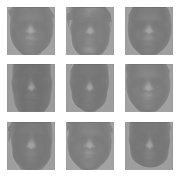

memory.used [MiB]
10490 MiB


In [34]:
!nvidia-smi --query-gpu=memory.used --format=csv
train(train_dataset, EPOCHS)
!nvidia-smi --query-gpu=memory.used --format=csv

Restore the latest checkpoint.

In [35]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [36]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('./gan_outputs/epoch_images/image_at_epoch_{:04d}.png'.format(epoch_no))

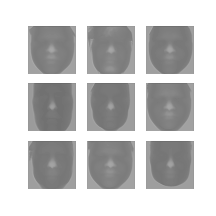

In [37]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [41]:
anim_file = './gan_outputs/dcgan_high_res.gif'
import imageio
with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('./gan_outputs/epoch_images/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


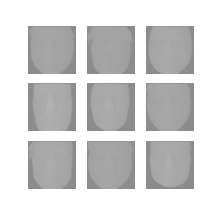

In [42]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

## Save Models

This tutorial has shown the complete code necessary to write and train a GAN. As a next step, you might like to experiment with a different dataset, for example the Large-scale Celeb Faces Attributes (CelebA) dataset [available on Kaggle](https://www.kaggle.com/jessicali9530/celeba-dataset). To learn more about GANs we recommend the [NIPS 2016 Tutorial: Generative Adversarial Networks](https://arxiv.org/abs/1701.00160).


In [40]:
# print(os.getcwd())
from datetime import date
today = date.today()
d = today.strftime("%b-%d-%Y")
# print(d)

generator.save('../Models/GANs/'+d+'_error_generator')
discriminator.save('../Models/GANs/'+d+'_error_discriminator')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../Models/GANs/May-03-2021_error_generator/assets
INFO:tensorflow:Assets written to: ../Models/GANs/May-03-2021_error_discriminator/assets
